# Rangefinder Spoofing a Live Drone (-5m Offset, -1cm/update Strength)
In this analysis we will be looking at a quadcopter flown to several meters up,
set to loiter mode, and then rangefinder spoofing simulated on the autopilot.
The rangefinder spoofing attack written into the autopilot is enabled by
parameters in the ground control station (GCS) with the target offset of -5m
with a strength of -1cm per rangefinder update. The expectation is for the
autopilot to interpret the decreasing rangefinder readings as the drone falling
and respond by flying the quadcopter upwards.
The data file can be found in the data subdirectory. Only interim data will be
available on github to preserve storage. For raw log files please contact me at
srimoungchanh.bailey@ku.edu.


For additional information about each sensor pair used in confirmation or a
more detailed explanation of the process refer to the no attack
[exploration notebook](./0.1-bks-exploration.ipynb) using simulation data.

## Data Processing
The log `file` needs to be parsed out as the format is irregular, starting with
a csv of rows prefixed with FMT, indicating the log type and format. The FMT
rows will be parsed into headers and then the subsequent rows will be matched
on log name, i.e., "__SNS1__", and added to their
respective dataframes. The dataframes are then unioned on their timestamps to
create a single dataframe with all of the __SNS__ data. If an `output` path is
provided the newly created dataframe will be written to the path as a CSV.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import numpy as np
from confirmation.process import process_SNS
from os.path import exists

#Convert log file from Mission Planner to usable CSV
data_dir = "../data/"
file = "Live-C-Idle-Attack-RF-5m-1cm.log" #Change file for different log files
output = data_dir + "interim/" + file[:-3] + "csv"

#Check if file exists already and if it does skip processing and read the file
if not exists(output):
    #Open log file and parse out the SNS data into pandas dataframes
    df = process_SNS(data_dir + "raw/" + file, output)
else:
    df = pd.read_csv(output)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)

### Above-Ground-Level Distance
__Important details to keep in mind:__

* Barometer measures pressure and calculates altitude relative to another
barometer measurement.

* Rangefinder and the accelerometer are both susceptible to attitude. The
rangefinder reads whatever the laser sensor mounted on the bottom of the
quadcopter is pointed at which when the quadcopter is at an angle becomes
skewed. The accelerometer by itself can only correctly read the downward
direction when the platform is level, otherwise the body frame and ECEF frame
become misaligned and the downward readings become incorrect.

* GPS altitude readings are most likely the most accurate of the collection of
sensors but has more restrictions in use such as satellite count, terrain, 
relative readings, and filter health.


For functions used in cleaning up data refer to the
[process.py](../src/confirmation/process.py) file.

First we will look at the change in altitude rather than the raw altitude. This
approach has the benefit of ignoring the absolute altitude reading and focus on
the changes in the signal, avoiding problems with calibration or initial biases
.

trap_integrate:   0%|          | 0/11243 [00:00<?, ?it/s]

trap_integrate:   0%|          | 0/11242 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/297 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/1477 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/148 [00:00<?, ?it/s]

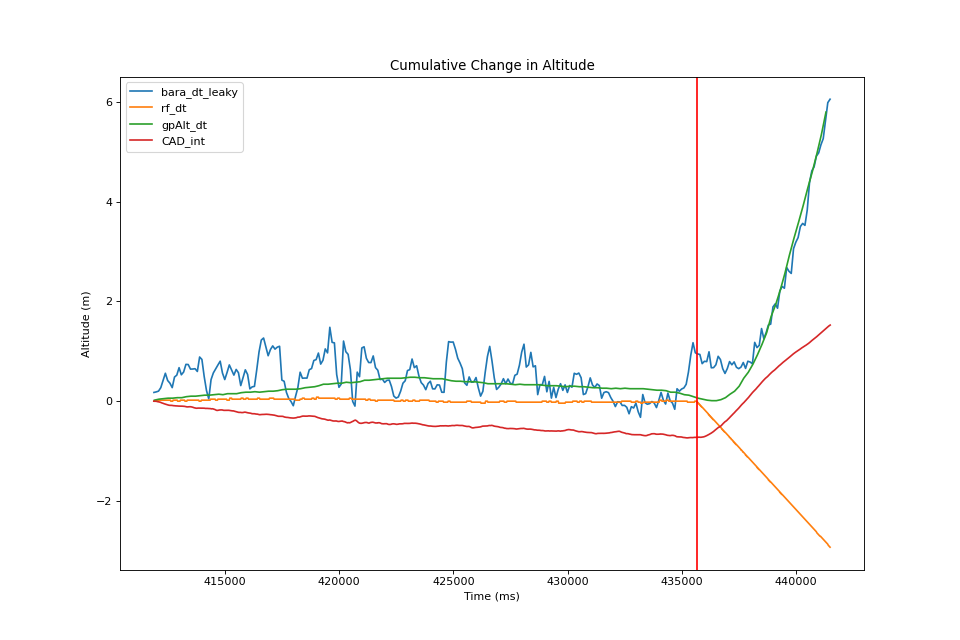

In [2]:
from confirmation.process import change_in_signal, leaky_integrator, trap_integrate
from confirmation.visualize import simple_time_plot
#Need the change_in_signal function to compare change in the percieved altitude
#rather than the raw altitude. 

#Remove duplicate rows for each signal
cUS = df[df.cUS.shift() != df.cUS][["cUS","CAD"]].reset_index()
rfMS = df[df.rfMS.shift() != df.rfMS][["rfMS","rf"]].reset_index()
barms = df[df.barms.shift() != df.barms][["barms","bara"]].reset_index()
gpsMS = df[df.gpsMS.shift() != df.gpsMS][["gpsMS","gpAlt"]].reset_index()

#Negate downward accelerometer because up is positive for other 3 sensors
acc_alt = trap_integrate(cUS.cUS/1000000, -cUS["CAD"])
acc_alt2 = trap_integrate(cUS.cUS/1000000, acc_alt)
#Applying leaky integrator to remove some of the spikes in barometer data
bar_alt = leaky_integrator(change_in_signal(barms.bara),alpha=0.7)
rf_alt = change_in_signal(rfMS.rf/100)
gp_alt = change_in_signal(gpsMS.gpAlt/100)

atk = 435647900
times = [0, atk/1000]
simple_time_plot([barms.barms[1:],
                  rfMS.rfMS[1:],
                  gpsMS.gpsMS[1:],
                  cUS.cUS[1:]/1000],
                 [bar_alt.cumsum(),
                  rf_alt.cumsum(),
                  gp_alt.cumsum(),
                  acc_alt.cumsum()],
                 atk=atk/1000,
                title="Cumulative Change in Altitude",
                units=["ms","Altitude (m)"])

We see that before the attack is launched the rangefinder, GPS, and
accelerometer all track relatively closely. Interestingly the barometer shows
large noise values which were not appropriately represented in the 
[rf spoofing in simulation notebook](./0.1-bks-attack-idle-rf.ipynb). This may
not be an issue as there is an obvious deviation from the values the barometer
is oscillating about at the point of attack. Further on in the statistics
section we will determine if the sensor provides meaningful confirmation. The
important detail is the divergence at the point of spoofing. The rangefinder
starts to drop 5 meters which was the desired value set in the attack
parameters while in response the barometer, gps, and accelerometer all start
accelerating upward. The divergence in readings is what we wish to see for
confirmation. The time frame for linear biasing for this data will be the
entire time before the attack displayed as the data was already trimmed to only
the 20 second section before the attack and ends when manual control is taken
back.

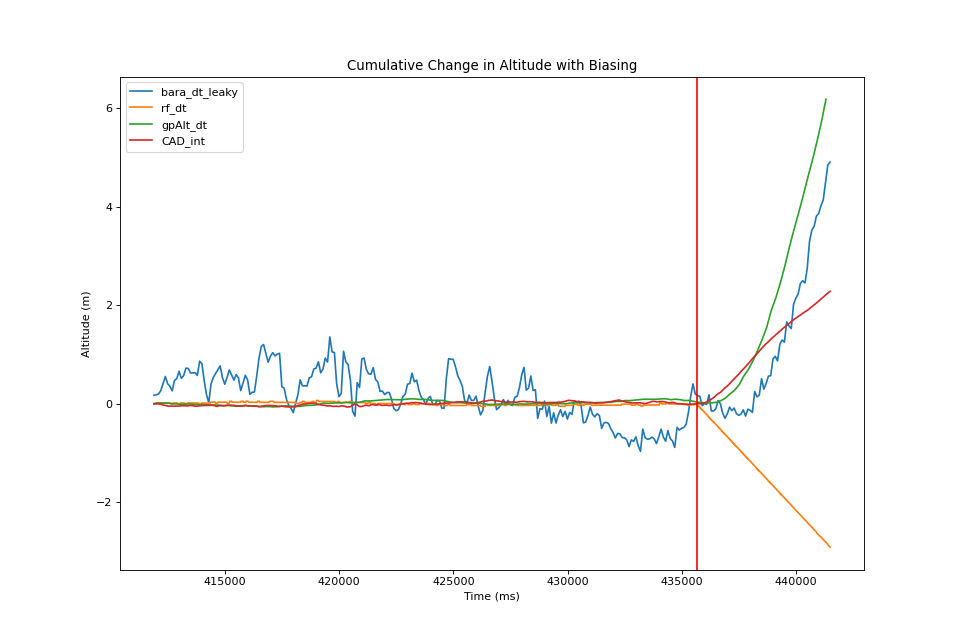

In [3]:
#linear_bias removes a percieved first order drift from the signal. In this
#case the index of time from 0:atk/1000 represents the loiter portion of the
#mission without any attack
from confirmation.process import linear_bias

simple_time_plot([barms.barms[1:],
                  rfMS.rfMS[1:],
                  gpsMS.gpsMS[1:],
                  cUS.cUS[1:]/1000],
                 [linear_bias(barms.barms[1:], bar_alt, times).cumsum(),
                  linear_bias(rfMS.rfMS[1:], rf_alt, times).cumsum(),
                  linear_bias(gpsMS.gpsMS[1:], gp_alt, times).cumsum(),
                  linear_bias(cUS.cUS[1:]/1000, acc_alt, times).cumsum()],
                 atk=atk/1000,
                title="Cumulative Change in Altitude with Biasing",
                units=["ms","Altitude (m)"])

As compared to the linear biasing performed in the simulation notebook, here
the linear biasing tightens the data far better and provides meaningful
improvement to our error margins.

#### Windowing

A method for reducing low frequency noise, or a slow drifting bias, is to only
look at sections of the data over time. Methods for looking at sections of the
data can be referred to as filtering, moving averages, windowing, or so forth.
The linear biasing applied before is a method of trying to remove any drift
that can be simply modeled by a linear equation when calibrating the senors in
a static position. What was also used before is the cumulative sum of changes
meaning any change in the signal whether due to noise or actual movement will
forever be kept in the result. It is more difficult to visually derive a window
size in seconds from the above figure as there is no obvious spike in data that
describes the attack. Here we will set the window size to 2 seconds to match
the amount of time the non-linear portion of the deviation takes place when the
benign sensors start trending upwards.

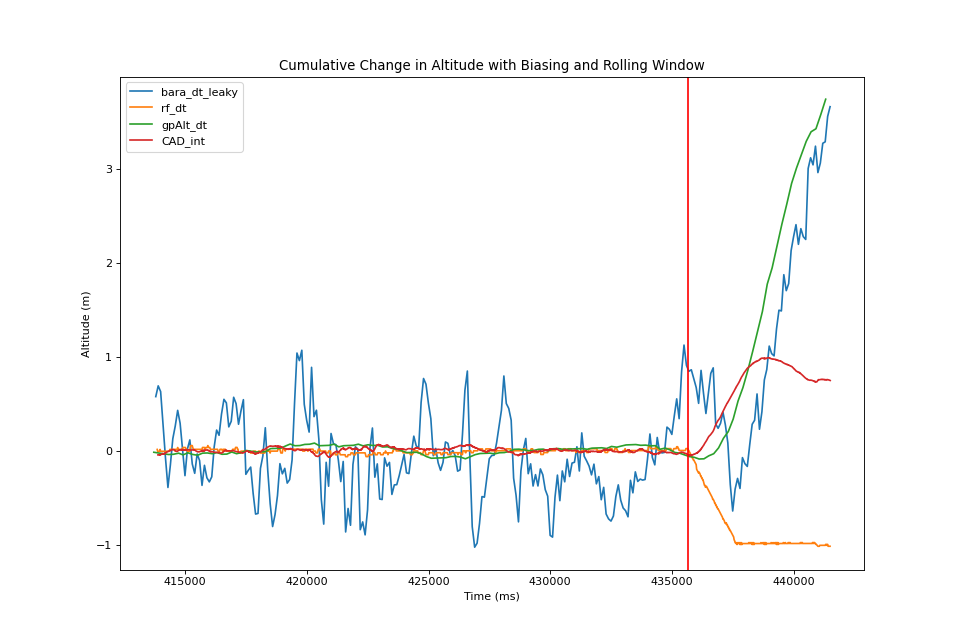

In [4]:
from math import floor

window_seconds = 2
#Each signal has different window size
acc_size = floor(window_seconds * 1000000/cUS.cUS.diff().mean())
rf_size = floor(window_seconds * 1000/rfMS.rfMS.diff().mean())
gps_size = floor(window_seconds * 1000/gpsMS.gpsMS.diff().mean())
bar_size = floor(window_seconds * 1000/barms.barms.diff().mean())

simple_time_plot([barms.barms[1:],
                  rfMS.rfMS[1:],
                  gpsMS.gpsMS[1:],
                  cUS.cUS[1:]/1000],
                 [linear_bias(barms.barms[1:], bar_alt, times).rolling(bar_size).sum(),
                  linear_bias(rfMS.rfMS[1:], rf_alt, times).rolling(rf_size).sum(),
                  linear_bias(gpsMS.gpsMS[1:], gp_alt, times).rolling(gps_size).sum(),
                  linear_bias(cUS.cUS[1:]/1000, acc_alt, times).rolling(acc_size).sum()],
                 atk=atk/1000,
                title="Cumulative Change in Altitude with Biasing and Rolling Window",
                units=["ms","Altitude (m)"])

Alright great, we have what appears to be signals that are almost the same with
significant differences removed from the results over time because of the
windowing. Now that we have the final representation of our signals we can look
at the statistics of the signal differences. The function 
`signal_match_and_cumsum` will take two signals, sum the faster signal readings
in between the slower signal updates and save the results when the slower
signal does update. The purpose of this is the different update rates requires
some form of interpolation to fill in data at the appropriate timestamps to 
directly compare the signals. To reduce the amount of signal that is loss at
the point of confirmation the faster signal is essentially "binned" into the
slower sensors time frames. To verify the correct implementation both the
original and "binned" signals are shown below which will be the same if
implemented properly.

In [5]:
test1 = change_in_signal(barms.bara)
test2 = change_in_signal(gpsMS.gpAlt/100)

change_in_signal:   0%|          | 0/297 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/148 [00:00<?, ?it/s]

In [6]:
x_ts = barms.barms[1:].reset_index(drop=True)
y_ts = gpsMS.gpsMS[1:].reset_index(drop=True)

change_in_signal:   0%|          | 0/297 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/148 [00:00<?, ?it/s]

signal_match_and_cumsum:   0%|          | 0/148 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/297 [00:00<?, ?it/s]

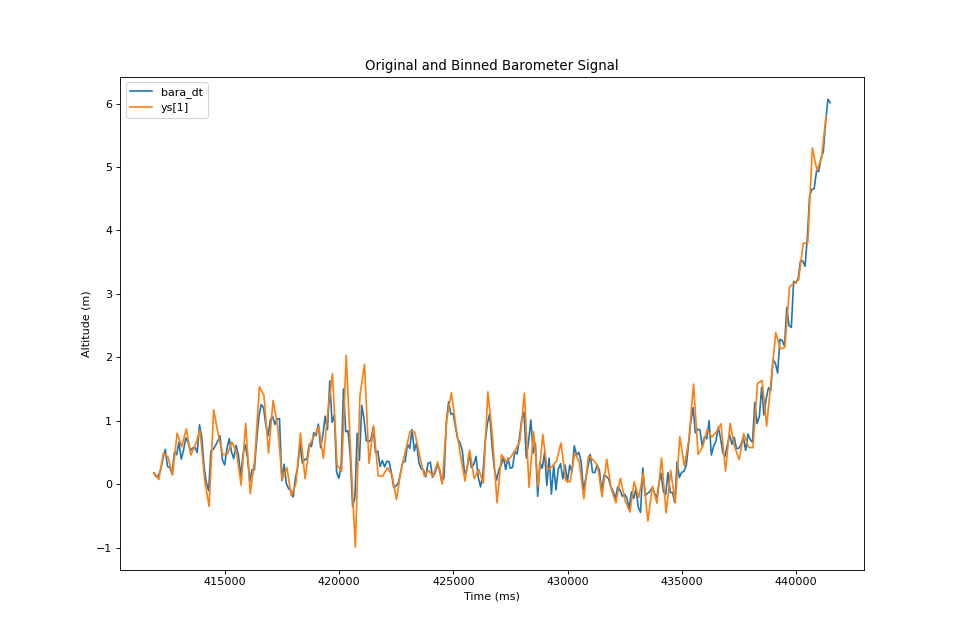

In [7]:
from confirmation.process import signal_match_and_cumsum
res = signal_match_and_cumsum(barms.barms[1:].reset_index(drop=True),
                              change_in_signal(barms.bara),
                              gpsMS.gpsMS[1:].reset_index(drop=True),
                              change_in_signal(gpsMS.gpAlt/100))
simple_time_plot([x_ts, y_ts],
                 [change_in_signal(barms.bara).cumsum(), res],
                title="Original and Binned Barometer Signal",
                units=["ms","Altitude (m)"])

Great, exactly what we want to see. Both signals when plotted with pyplot will
be interpolated to fit the same axis by default, but what is important is that
these signals have different lengths due to being binned. Although the signals
have different lengths they represent the same signal, except one is now in a
form that can be compared to the GPS signal.

The attack is clearly noticable in the windowed data. The divergence at where
the attack starts is consistent and should be easily detected. We will take a
closer look at the actual signal behavior below to see how these simulated
results compare to datasheet error estimates.

## Statistics of These Signals Compared to Theory

Now that these signals are grouped well enough we can start looking at the
statistical details of the signals and how they relate to determine if sensor
confirmation would be possible here. The simplest approach taken is to take
the absolute difference in any 2 signals and determine at what value 99.7% of
the signals fall below. Finding where 99.7% of values fall under is the
sensor confirmation approach that wants to consider signal differences and
compare the result to datasheet reported or empirically derived noise
distributions.

### Confirming an Attacked and Benign Signal
#### RF and Barometer
##### With Window

In [8]:
#Matching rangefinder to the barometers update rate
rf = signal_match_and_cumsum(rfMS.rfMS[1:].reset_index(drop=True), change_in_signal(rfMS.rf/100),
                            barms.barms[1:].reset_index(drop=True), change_in_signal(barms.bara))

rf = linear_bias(barms.barms[3:], change_in_signal(rf), times).rolling(bar_size).sum()
rf = pd.Series(rf, name="rf_dt")

bar = linear_bias(barms.barms[1:], bar_alt, times).rolling(bar_size).sum()

#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = barms.barms[barms.barms < atk/1000][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("Bar and RF during benign 99.7%%: %.5fm" % np.percentile(abs(bar - rf)[:atk_index].dropna(), 99.7))
print("Bar and RF during attack 99.7%%: %.5fm" % np.percentile(abs(bar - rf)[atk_index:].dropna(), 99.7))

change_in_signal:   0%|          | 0/1477 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/297 [00:00<?, ?it/s]

signal_match_and_cumsum:   0%|          | 0/297 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/295 [00:00<?, ?it/s]

Bar and RF during benign 99.7%: 1.07006m
Bar and RF during attack 99.7%: 4.24392m


##### No Window

In [9]:
#Matching rangefinder to the barometers update rate
rf = signal_match_and_cumsum(rfMS.rfMS[1:].reset_index(drop=True), change_in_signal(rfMS.rf/100),
                            barms.barms[1:].reset_index(drop=True), change_in_signal(barms.bara))

rf = linear_bias(barms.barms[3:], change_in_signal(rf), times).cumsum()
rf = pd.Series(rf, name="rf_dt")

bar = linear_bias(barms.barms[1:], bar_alt, times).cumsum()

#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = barms.barms[barms.barms < atk/1000][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("Bar and RF during benign 99.7%%: %.5fm" % np.percentile(abs(bar - rf)[:atk_index].dropna(), 99.7))
print("Bar and RF during attack 99.7%%: %.5fm" % np.percentile(abs(bar - rf)[atk_index:].dropna(), 99.7))

change_in_signal:   0%|          | 0/1477 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/297 [00:00<?, ?it/s]

signal_match_and_cumsum:   0%|          | 0/297 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/295 [00:00<?, ?it/s]

Bar and RF during benign 99.7%: 1.22774m
Bar and RF during attack 99.7%: 7.06399m


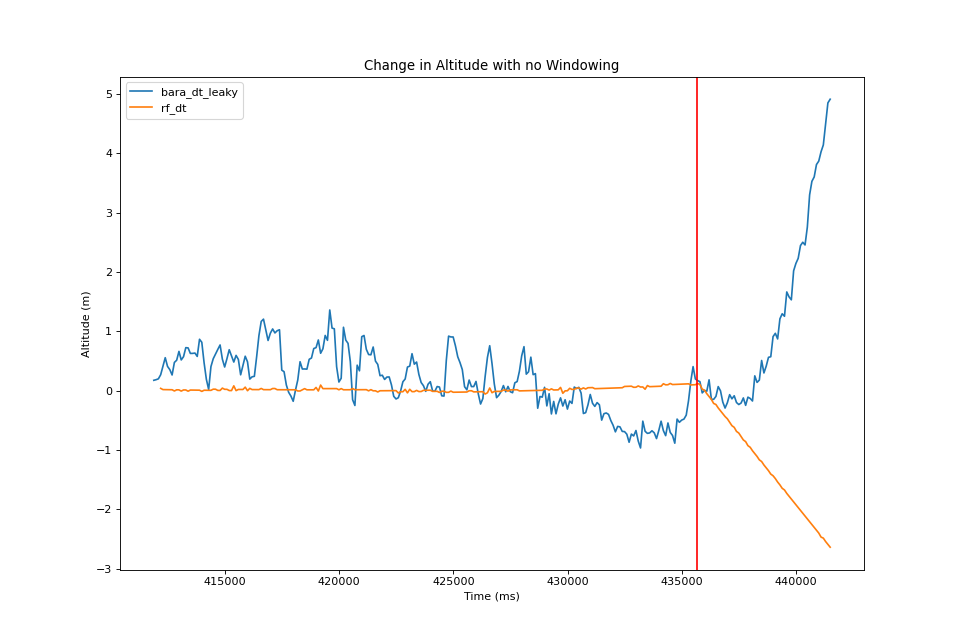

In [10]:
simple_time_plot([barms.barms[1:], barms.barms[4:]],
                 [bar, rf[1:]],
                title = "Change in Altitude with no Windowing",
                units = ["ms","Altitude (m)"],
                atk=atk/1000)

#### RF and GPS
##### With Window

In [11]:
#Matching RF to GPS update rate
rf = signal_match_and_cumsum(rfMS.rfMS[1:].reset_index(drop=True), change_in_signal(rfMS.rf/100),
                            gpsMS.gpsMS[1:].reset_index(drop=True), change_in_signal(gpsMS.gpAlt))

rf = linear_bias(gpsMS.gpsMS[2:], change_in_signal(rf), times).rolling(gps_size).sum()
rf = pd.Series(rf, name="rf_dt")

gps = linear_bias(gpsMS.gpsMS[1:], gp_alt, times).rolling(gps_size).sum()

#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = gpsMS.gpsMS[gpsMS.gpsMS < atk/1000][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("GPS and RF during benign 99.7%%: %.5fm" % np.percentile(abs(rf - gps)[:atk_index].dropna(), 99.7))
print("GPS and RF during attack 99.7%%: %.5fm" % np.percentile(abs(rf - gps)[atk_index:].dropna(), 99.7))

change_in_signal:   0%|          | 0/1477 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/148 [00:00<?, ?it/s]

signal_match_and_cumsum:   0%|          | 0/148 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/147 [00:00<?, ?it/s]

GPS and RF during benign 99.7%: 0.10510m
GPS and RF during attack 99.7%: 4.50435m


##### No Window

In [12]:
#Matching RF to GPS update rate
rf = signal_match_and_cumsum(rfMS.rfMS[1:].reset_index(drop=True), change_in_signal(rfMS.rf/100),
                            gpsMS.gpsMS[1:].reset_index(drop=True), change_in_signal(gpsMS.gpAlt))

rf = linear_bias(gpsMS.gpsMS[2:], change_in_signal(rf), times).cumsum()
rf = pd.Series(rf, name="rf_dt")

gps = linear_bias(gpsMS.gpsMS[1:], gp_alt, times).cumsum()

#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = gpsMS.gpsMS[gpsMS.gpsMS < atk/1000][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("GPS and RF during benign 99.7%%: %.5fm" % np.percentile(abs(rf - gps)[:atk_index].dropna(), 99.7))
print("GPS and RF during attack 99.7%%: %.5fm" % np.percentile(abs(rf - gps)[atk_index:].dropna(), 99.7))

change_in_signal:   0%|          | 0/1477 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/148 [00:00<?, ?it/s]

signal_match_and_cumsum:   0%|          | 0/148 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/147 [00:00<?, ?it/s]

GPS and RF during benign 99.7%: 0.13231m
GPS and RF during attack 99.7%: 8.21583m


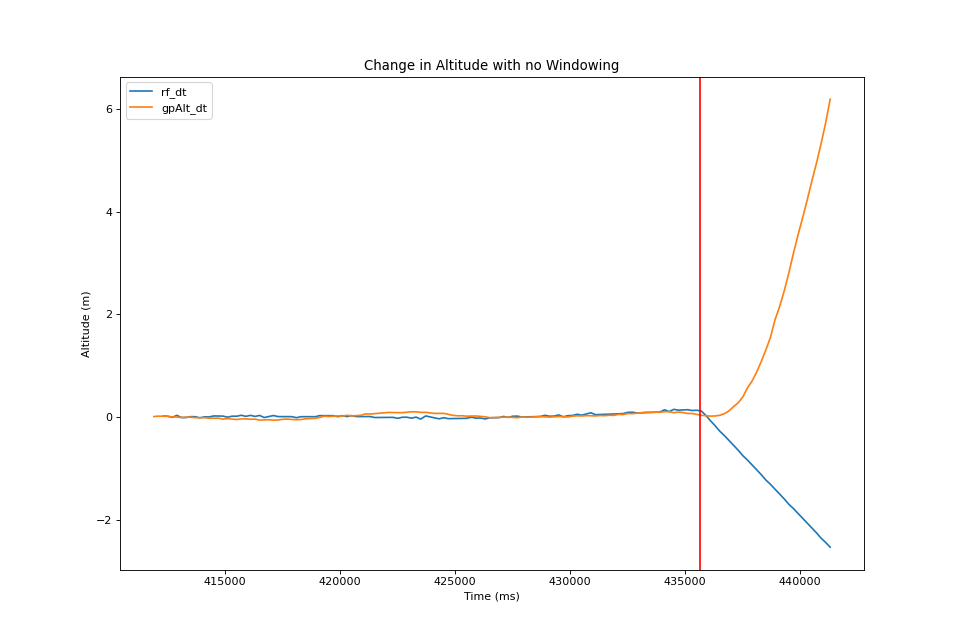

In [13]:
simple_time_plot([gpsMS.gpsMS[3:], gpsMS.gpsMS[1:]],
                 [rf[1:], gps],
                title = "Change in Altitude with no Windowing",
                units = ["ms","Altitude (m)"],
                atk=atk/1000)

#### RF and Acc
##### With Window

In [14]:
#Matching Acc to RF update rate
acc = signal_match_and_cumsum((cUS.cUS[1:]/1000).reset_index(drop=True), trap_integrate(cUS.cUS/1000000, -cUS["CAD"]),
                            rfMS.rfMS[1:].reset_index(drop=True), change_in_signal(rfMS.rf/100))

acc = linear_bias(rfMS.rfMS[2:], change_in_signal(acc), times).rolling(rf_size).sum()
acc = pd.Series(acc, name="acc_dt")

rf = linear_bias(rfMS.rfMS[1:], rf_alt, times).rolling(rf_size).sum()

#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = rfMS.rfMS[rfMS.rfMS < atk/1000][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("Acc and RF during benign 99.7%%: %.5fm" % np.percentile(abs(acc - rf)[:atk_index].dropna(), 99.7))
print("Acc and RF during attack 99.7%%: %.5fm" % np.percentile(abs(acc - rf)[atk_index:].dropna(), 99.7))

trap_integrate:   0%|          | 0/11243 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/1477 [00:00<?, ?it/s]

signal_match_and_cumsum:   0%|          | 0/1477 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/1476 [00:00<?, ?it/s]

Acc and RF during benign 99.7%: 0.10137m
Acc and RF during attack 99.7%: 1.96891m


##### No Window

In [15]:
#Matching Acc to RF update rate
acc = signal_match_and_cumsum((cUS.cUS[1:]/1000).reset_index(drop=True), trap_integrate(cUS.cUS/1000000, -cUS["CAD"]),
                            rfMS.rfMS[1:].reset_index(drop=True), change_in_signal(rfMS.rf/100))

acc = linear_bias(rfMS.rfMS[2:], change_in_signal(acc), times).cumsum()
acc = pd.Series(acc, name="acc_dt")

rf = linear_bias(rfMS.rfMS[1:], rf_alt, times).cumsum()

#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = rfMS.rfMS[rfMS.rfMS < atk/1000][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("Acc and RF during benign 99.7%%: %.5fm" % np.percentile(abs(acc - rf)[:atk_index].dropna(), 99.7))
print("Acc and RF during attack 99.7%%: %.5fm" % np.percentile(abs(acc - rf)[atk_index:].dropna(), 99.7))

trap_integrate:   0%|          | 0/11243 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/1477 [00:00<?, ?it/s]

signal_match_and_cumsum:   0%|          | 0/1477 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/1476 [00:00<?, ?it/s]

Acc and RF during benign 99.7%: 0.10983m
Acc and RF during attack 99.7%: 5.16554m


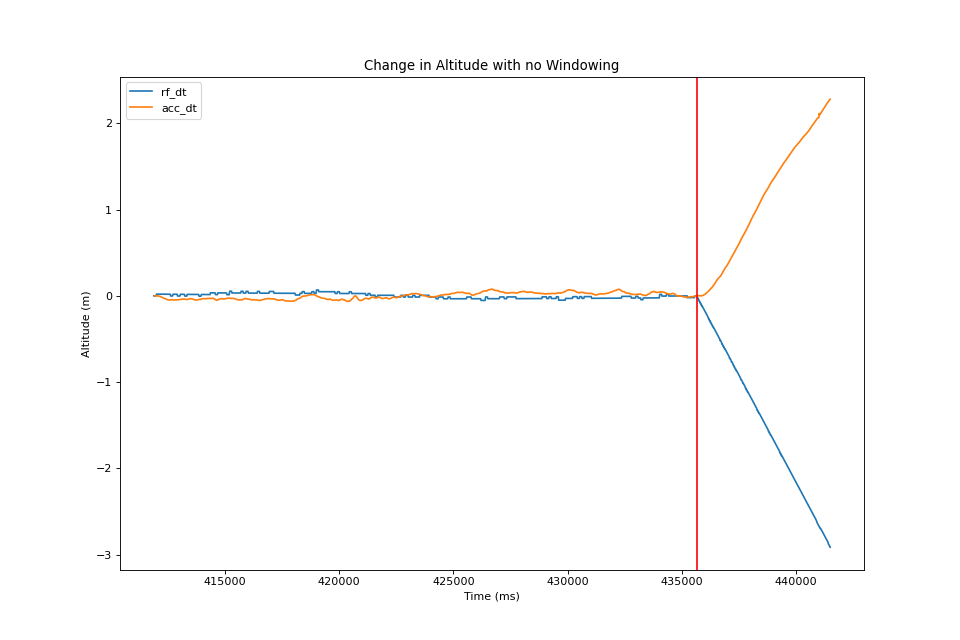

In [16]:
simple_time_plot([rfMS.rfMS[1:],rfMS.rfMS[3:]],
                 [rf, acc[1:]],
                title = "Change in Altitude with no Windowing",
                units = ["ms","Altitude (m)"],
                atk=atk/1000)

The results for comparing the rangefinder to the other signals shows promising
results with significant differences between the benign and malicious portions
of the signals. What we need to consider now is how the benign signals pair to
one another as those error margins will be relevant in performing the
confirmation in a benign setting.

### Confirming Benign Signals
#### Barometer and GPS

In [17]:
#Matching Bar to GPS update rate
bar = signal_match_and_cumsum(barms.barms[1:].reset_index(drop=True), change_in_signal(barms.bara),
                            gpsMS.gpsMS[1:].reset_index(drop=True), change_in_signal(gpsMS.gpAlt))

bar = linear_bias(gpsMS.gpsMS[2:], change_in_signal(bar), times).rolling(gps_size).sum()
bar = pd.Series(bar, name="bar_dt")

gps = linear_bias(gpsMS.gpsMS[1:], gp_alt, times).rolling(gps_size).sum()

#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = gpsMS.gpsMS[gpsMS.gpsMS < atk/1000][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("Acc and RF during benign 99.7%%: %.5fm" % np.percentile(abs(gps - bar)[:atk_index].dropna(), 99.7))
print("Acc and RF during attack 99.7%%: %.5fm" % np.percentile(abs(gps - bar)[atk_index:].dropna(), 99.7))

change_in_signal:   0%|          | 0/297 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/148 [00:00<?, ?it/s]

signal_match_and_cumsum:   0%|          | 0/148 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/147 [00:00<?, ?it/s]

Acc and RF during benign 99.7%: 2.06524m
Acc and RF during attack 99.7%: 1.45897m


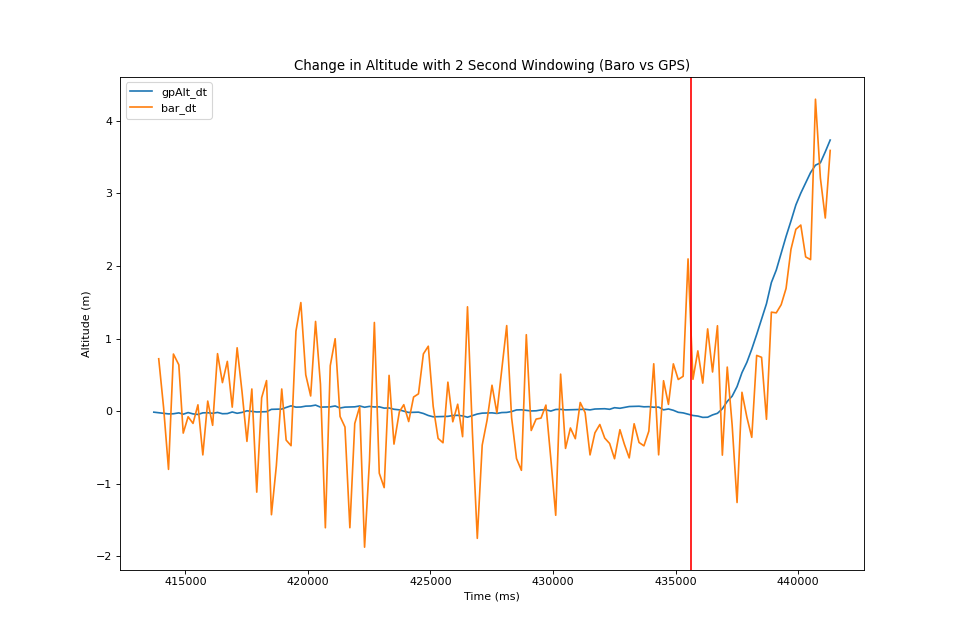

In [18]:
simple_time_plot([gpsMS.gpsMS[1:],gpsMS.gpsMS[3:]],
                 [gps, bar[1:]],
                title = "Change in Altitude with " + str(window_seconds) + " Second Windowing (Baro vs GPS)",
                units = ["ms","Altitude (m)"],
                atk=atk/1000)

#### Barometer and Acc

In [19]:
#Matching Acc to RF update rate
acc = signal_match_and_cumsum((cUS.cUS[1:]/1000).reset_index(drop=True), trap_integrate(cUS.cUS/1000000, -cUS["CAD"]),
                            barms.barms[1:].reset_index(drop=True), change_in_signal(barms.bara))

acc = linear_bias(barms.barms[2:], change_in_signal(acc), times).rolling(bar_size).sum()
acc = pd.Series(acc, name="acc_dt")

bar = linear_bias(barms.barms[1:], bar_alt, times).rolling(bar_size).sum()

#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = barms.barms[barms.barms < atk/1000][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("Acc and RF during benign 99.7%%: %.5fm" % np.percentile(abs(acc - bar)[:atk_index].dropna(), 99.7))
print("Acc and RF during attack 99.7%%: %.5fm" % np.percentile(abs(acc - bar)[atk_index:].dropna(), 99.7))

trap_integrate:   0%|          | 0/11243 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/297 [00:00<?, ?it/s]

signal_match_and_cumsum:   0%|          | 0/297 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/296 [00:00<?, ?it/s]

Acc and RF during benign 99.7%: 1.09132m
Acc and RF during attack 99.7%: 2.77821m


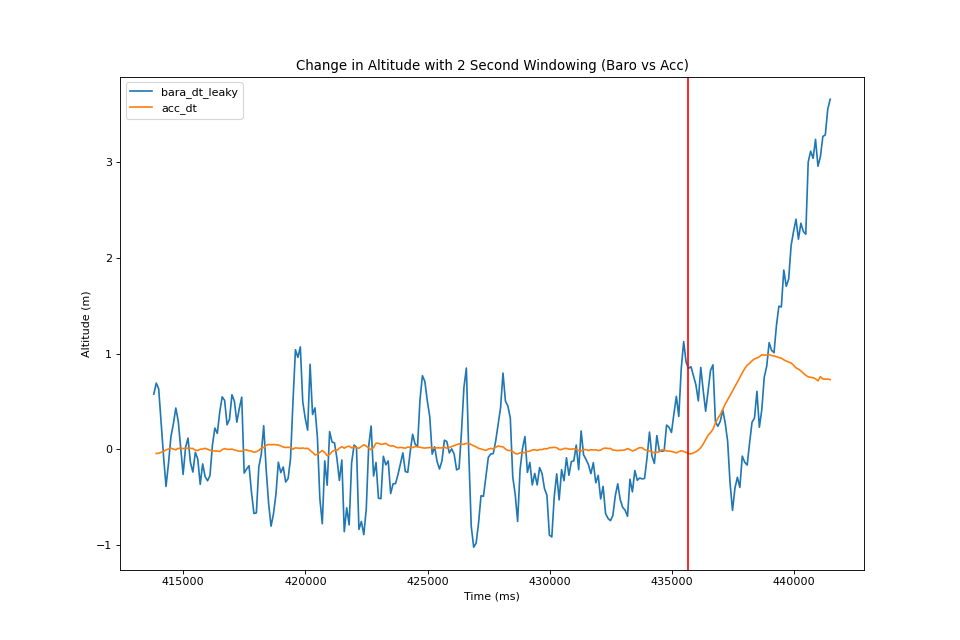

In [20]:
simple_time_plot([barms.barms[1:], barms.barms[3:]],
                 [bar, acc[1:]],
                title = "Change in Altitude with " + str(window_seconds) + " Second Windowing (Baro vs Acc)",
                units = ["ms","Altitude (m)"],
                atk=atk/1000)

#### Acc vs GPS

In [32]:
#Matching Acc to RF update rate
acc = signal_match_and_cumsum((cUS.cUS[1:]/1000).reset_index(drop=True), trap_integrate(cUS.cUS/1000000, -cUS["CAD"]),
                            gpsMS.gpsMS[1:].reset_index(drop=True), change_in_signal(gpsMS.gpAlt))

acc = linear_bias(gpsMS.gpsMS[2:], change_in_signal(acc), times).rolling(gps_size).sum()
acc = pd.Series(acc, name="acc_dt")

gps = linear_bias(gpsMS.gpsMS[1:], gp_alt, times).rolling(gps_size).sum()

#We need the index at which the attack starts since the signals ahve lost their
#timestamps during processing
atk_index = gpsMS.gpsMS[gpsMS.gpsMS < atk/1000][-1:].index[0]

#Calculate the value at which 99.7% of points fall below for both the benign
#and attacked setting
print("Acc and RF during benign 99.7%%: %.5fm" % np.percentile(abs(acc - gps)[:atk_index].dropna(), 99.7))
print("Acc and RF during attack 99.7%%: %.5fm" % np.percentile(abs(acc - gps)[atk_index:].dropna(), 99.7))

trap_integrate:   0%|          | 0/11243 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/148 [00:00<?, ?it/s]

signal_match_and_cumsum:   0%|          | 0/148 [00:00<?, ?it/s]

change_in_signal:   0%|          | 0/147 [00:00<?, ?it/s]

Acc and RF during benign 99.7%: 0.14127m
Acc and RF during attack 99.7%: 2.82587m


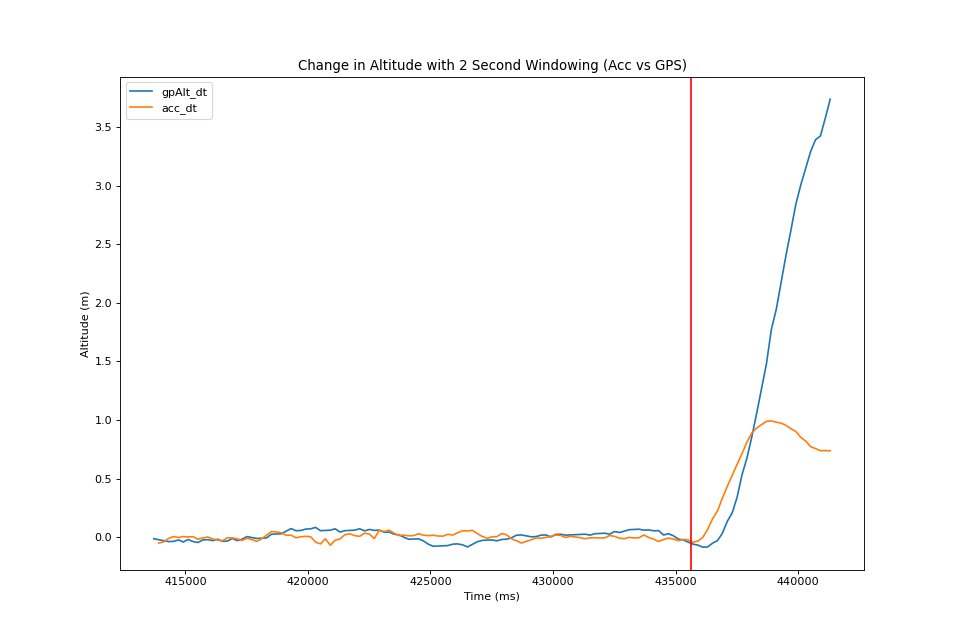

In [33]:
simple_time_plot([gpsMS.gpsMS[1:], gpsMS.gpsMS[3:]],
                 [gps, acc[1:]],
                title = "Change in Altitude with " + str(window_seconds) + " Second Windowing (Acc vs GPS)",
                units = ["ms","Altitude (m)"],
                atk=atk/1000)

#### Conclusion

This notebook showed an analysis of simulated data with the purpose of seeing
whether sensor confirmation could be applied to detect an attack on the
rangefinder. We have shown that the magnitude of difference between a benign
setting and an attacked setting when using the more relaxed 2 second windows.
The difference in disagreement from the attacked portion of the data to the
benign was at worst 4 times, showing good promise for detecting an attacker. In
this attack we used the weakest attack strength per update rate, 1cm/s. A spoof
strength of 1cm/update on the rangefinder roughly equates to 50cm/s which is
more subtle than the attacks we've deployed so far on the GPS. The barometer
has proven to have wide error margins in the benign cases we demonstrated above
which could prove problematic in the future and warrants further exploration.
Additionally the accelerometer tapering off due to the windowing causes some
disagreement that may also be problematic warranting another look at the window
approach.
